**Tabla de contenido**

- [Introducción](#Introduccion)
- [Requisitos](#Requisitos)
- [Lectura de datos](#Lectura-de-datos)
- [EDA](#EDA)
    - [Box Plot](#Box-Plot)
    - [Histogramas](#Histogramas)
    - [distribución de clases](#distribucion-de-clases)
    - [Resumen](#Resumen)
- [Preprocesamiento](#Preprocesamiento)
    - [Medcouple](#Medcouple)
    - [Matriz oro](#Matriz-oro)
    - [Matriz platino](#Matriz-platino)
- [Respuestasa preguntas EDA](#Respuestasa-preguntas-EDA)
- [feature engineering](#feature-engineering)
- [Escalado de datos](#Escalado-de-datos)
- [Balanceo de clases](#Balanceo-de-clases)

# Introduccion

En este cuaderno trabajaremos con la base de datos *covalto_sme_credit_data.csv* con el objetivo de desarrollar un modelo predictivo que estime la probabilidad de que un solicitante de crédito PYME incurra en incumplimiento dentro de los siguientes 12 meses.

El análisis buscará responder tres preguntas clave:

- Identificar los principales factores que explican el incumplimiento crediticio.

- Estimar un score de riesgo (probabilidad de incumplimiento) para cada solicitante.

- Explorar cómo equilibrar el crecimiento del negocio con la gestión del riesgo a través de distintos umbrales de decisión.

- Finalmente, se entrenarán y evaluarán distintos modelos para comparar su desempeño y seleccionar la mejor alternativa para apoyar la toma de decisiones en la aprobación de créditos.

No siendo más, ¡comencemos!

# Requisitos

- Python 3.12.11
- Plotly
- Pandas
- Skalearn

# Lectura de datos

In [1]:
import pandas as pd
import numpy as np
import os

file_path = lambda file : os.path.join(os.getcwd(),'data',file)
credit_data = pd.read_csv(file_path('covalto_sme_credit_data.csv'))
credit_data.head()

id_cliente  antiguedad_empresa_anos        sector_industrial  \
0   COV-1000                      9.5              Manufactura   
1   COV-1001                      6.9             Construcción   
2   COV-1002                     10.2  Servicios Profesionales   
3   COV-1003                     15.8                   Retail   
4   COV-1004                      6.6                   Retail   

   ingresos_anuales_mxn  deuda_total_mxn  historial_pagos_atrasados  \
0            5388966.19       4093290.34                          1   
1             806689.27        184032.16                          3   
2            4721557.55       2875892.65                          1   
3             400301.58        284881.54                          1   
4            6110431.90       5935242.68                          2   

  calificacion_buro  default_12m  monto_solicitado_mxn  
0                 D            0            1042088.49  
1                 C            0             658716.30  
2                 B            0             656435.67  
3                 B            0             289018.04  
4               NaN            0             694186.35

# EDA

El propósito principal del análisis exploratorio de datos es comprender el estado y las características de la información antes de decidir qué técnicas de ciencia de datos o machine learning aplicar. Eso implica organizar los datos, conocer su contenido, identificar las variables más relevantes y analizar como se relacionan entre sí, detectar patrones, evaluar la presencia de datos faltantes y valores atípicos y finalmente extraer conclusiones apartir de este proceso.

En general el EDA busca obtener una visión de cómo estan los datos, y para esto realizaremos las siguientes etapas:

- Consultar la cantidad de registros y columnas en la base de datos.
- Consultar los estadisticos básicos del dataframe
- Consultar los valores faltantes
- Evaluar la presencia de atípicos
- Analizar la distribución de los datos.

Estos puntos analizados nos dan paso al preprocesamiento de los datos, con lo cual buscamos obtener una matriz limpia que la llamaremos Matriz Oro, con esta buscaremos responder las preguntas de investigación para el análisis exploratorio.

1. Cuáles son los sectores industriales en donde los clientes presentan mayores ingresos anuales?
2. Cuáles son los sectores industrial en donde los clientes tienen más deuda?
3. Cuáles son las calificaciones buro con más historial de pagos atrazados.?
4. ¿Cuáles son los principales impulsores del incumplimiento crediticio entre nuestros clientes PYME?
5. ¿Cómo podemos cuantificar el riesgo asociado con cada nueva solicitud de préstamo?
6. ¿Cómo deberíamos equilibrar los objetivos de crecimiento del negocio (aprobar más préstamos) con la mitigación de riesgos (minimizar los incumplimientos)?

`Hipotesis inicial`: La deuda total es el prinicial inpulsor de incumplimiento

Dicho esto, procedamos con la exploración de los datos.

In [2]:
print(f"la cantidad de resgistros que tiene el dataframe son: {credit_data.shape[0]}")
print(f"La cantidad de características son: {credit_data.shape[1]}")

la cantidad de resgistros que tiene el dataframe son: 1500
La cantidad de características son: 9


Podemos observar que la base de datos es pequeña con solo 1500 registros y 9 columnas o características. Veamos los estadísticos básicos.

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)
credit_data.describe()

antiguedad_empresa_anos  ingresos_anuales_mxn  deuda_total_mxn  \
count                  1425.00               1455.00          1500.00   
mean                      8.57            5415924.13       3145138.29   
std                       4.54            9924932.50       4365469.32   
min                       1.50             161517.32             0.00   
25%                       5.40            1595236.54        869855.46   
50%                       7.60            3097466.73       1745122.12   
75%                      10.40            5975456.75       3638661.85   
max                      50.70          289841674.60      55109672.87   

       historial_pagos_atrasados  default_12m  monto_solicitado_mxn  
count                    1500.00      1500.00               1500.00  
mean                        1.50         0.12             731527.56  
std                         1.22         0.32             994645.96  
min                         0.00         0.00              17658.70  
25%                         1.00         0.00             207512.72  
50%                         1.00         0.00             423847.26  
75%                         2.00         0.00             878026.50  
max                         7.00         1.00           15082643.26

Perfecto, no encontramos valores anómalos como -99999, lo que indica que, por el momento, no debemos preocuparnos por estos datos inusuales. Sin embargo, se pueden observar máximos muy elevados, lo que sugiere la posible presencia de valores atípicos.

Veamos ahora si hay valores faltantes.

In [4]:
credit_data.isnull().sum()

id_cliente                     0
antiguedad_empresa_anos       75
sector_industrial              0
ingresos_anuales_mxn          45
deuda_total_mxn                0
historial_pagos_atrasados      0
calificacion_buro            120
default_12m                    0
monto_solicitado_mxn           0
dtype: int64

Observamos que únicamente tres columnas presentan valores faltantes, las cuales son:

- antiguedad_empresa_anos
- ingresos_anuales_mxn
- calificación_buro

A continuación, revisemos si hay valores duplicados.

In [5]:
print(f"Duplicados (sin contar la primera aparición): {credit_data.duplicated().sum()}")

Duplicados (sin contar la primera aparición): 0


Esto es positivo; no hay registros duplicados. Ahora, examinemos qué tipos de datos contiene el dataframe.

In [6]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_cliente                 1500 non-null   object 
 1   antiguedad_empresa_anos    1425 non-null   float64
 2   sector_industrial          1500 non-null   object 
 3   ingresos_anuales_mxn       1455 non-null   float64
 4   deuda_total_mxn            1500 non-null   float64
 5   historial_pagos_atrasados  1500 non-null   int64  
 6   calificacion_buro          1380 non-null   object 
 7   default_12m                1500 non-null   int64  
 8   monto_solicitado_mxn       1500 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 105.6+ KB


`Variables numéricas (6):`

- antiguedad_empresa_anos
- ingresos_anuales_mxn
- deuda_total_mxn
- historial_pagos_atrasados
- default_12m
- monto_solicitado_mxn


`Variables categóricas (3):`

- id_cliente
- sector_industrial
- calificacion_buro

Perfecto, ya tenemos una idea clara del estado de los datos. La columna calificación_buro es categórica y presenta 120 valores faltantes. Además, solo dos columnas numéricas (antigüedad_empresa_anos e ingresos_anuales_mxn) contienen 75 y 45 valores faltantes, respectivamente. Por el momento, procederemos a visualizar los boxplots y las distribuciones de los datos. En la etapa de preprocesamiento, abordaremos los valores faltantes y los valores atípicos identificados.

## Box Plot

In [7]:
import plotly.graph_objects as go
import plotly.colors as pc
import plotly.express as px

def plot_boxplots(df, title='Boxplots por variable', height=300):
    """
    Genera un boxplot interactivo con colores variados para cada columna numérica del DataFrame.

    Parámetros:
    - df: pandas.DataFrame con los datos
    - title: título del gráfico
    - height: altura del gráfico en píxeles
    """
    fig = go.Figure()

    numeric_cols = df.select_dtypes(include='number').columns
    colors = pc.qualitative.Plotly  # paleta de colores categóricos

    for i, column in enumerate(numeric_cols):
        fig.add_trace(go.Box(
            y=df[column],
            name=column,
            boxpoints='outliers',
            marker=dict(size=4, color=colors[i % len(colors)]),
            line=dict(color=colors[i % len(colors)]),
            fillcolor=colors[i % len(colors)],
        ))

    fig.update_layout(
        title=title,
        yaxis_title='Valor',
        #boxmode='group',
        template='plotly_white',
        font=dict(family='Arial', size=14),
        margin=dict(l=40, r=40, t=60, b=80),
        height=height,
        showlegend=False,
        autosize=True,
    )

    fig.show()
credit_data.columns = credit_data.columns.str.strip()
plot_boxplots(credit_data, title='Distribución de variables numéricas', height=300)

## Histogramas

In [8]:
import plotly.subplots as sp
import plotly.graph_objects as go

def plot_histograms_grid(df, exclude_cols=['Date'], bins=None, title="Distribuciones"):
    """
    Genera un grid de histogramas para cada columna numérica del DataFrame,
    excluyendo las columnas especificadas en `exclude_cols`.

    Parámetros:
        df (pd.DataFrame): DataFrame de entrada.
        exclude_cols (list): Columnas a excluir (por defecto ['Date']).
        bins (int): Número de bins para los histogramas. Si es None, se calcula automáticamente.
        title (str): Título general de la figura.
    
    Retorna:
        fig (go.Figure): Figura con los subplots.
    """
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns        # Filtrar columnas numéricas y excluir las no deseadas
    cols_to_plot = numeric_cols.difference(exclude_cols)
    n = len(cols_to_plot)
    
    if n == 0:
        raise ValueError("No hay columnas numéricas para graficar.")
    
    
    if bins is None:                                                    # Calcular bins si no se especifica
        bins = int(2 * len(df)**(1/3))                                  # Regla de Sturges modificada
    
    cols_grid = min(3, n)                                               # Configuración del grid (máximo 4 columnas para mejor visualización)
    rows_grid = int(np.ceil(n / cols_grid))
    
    # Plantilla profesional
    professional_template = {
        'layout': go.Layout(
            font=dict(family="Arial", size=12, color="#333"),
            title=dict(font=dict(size=16, color="#333"), x=0.5, xanchor='center'),
            plot_bgcolor='white',
            paper_bgcolor='white',
            margin=dict(l=40, r=40, t=60, b=40),
            hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")
        )
    }
    
    # Crear figura con subplots
    fig = sp.make_subplots(
        rows=rows_grid,
        cols=cols_grid,
        subplot_titles=cols_to_plot,                                       # Pone los títulos a cada histograma
        horizontal_spacing=0.1,
        vertical_spacing=0.15
    )
    
    # Añadir histogramas
    for i, col in enumerate(cols_to_plot, 1):
        row = ((i - 1) // cols_grid) + 1
        col_pos = ((i - 1) % cols_grid) + 1
        
        fig.add_trace(
            go.Histogram(
                x=df[col],
                nbinsx=bins,
                marker=dict(
                    color='rgba(100, 149, 237, 0.7)',
                    line=dict(color='rgba(0, 0, 0, 0.5)', width=1)
                ),
                opacity=0.9,
                hovertemplate=f"{col}: %{{x}}<br>Frecuencia: %{{y}}<extra></extra>",
                name=col
            ),
            row=row, col=col_pos
        )
        
        # Personalizar ejes
        fig.update_xaxes(
            #title_text=col,                                # pone títulos a eje x
            row=row, col=col_pos,
            showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
            linecolor='black', linewidth=1
        )
        fig.update_yaxes(
            title_text="Frecuencia",
            row=row, col=col_pos,
            showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
            linecolor='black', linewidth=1
        )
    
    # Actualizar layout general
    fig.update_layout(
        height=300 * rows_grid,
        width=400 * min(cols_grid, 3),  # Evitar que sea demasiado ancho
        showlegend=False,
        template=professional_template,
        title_text=title,
        title_x=0.5
    )
    
    return fig

fig = plot_histograms_grid(credit_data, title="Distribuciones de variables numéricas")
fig.show()

In [9]:
for col in credit_data.select_dtypes(include=['number']).columns:
    print(f"Columna:{col}, Skewness:{credit_data[col].skew():.6f}")

Columna:antiguedad_empresa_anos, Skewness:1.877519
Columna:ingresos_anuales_mxn, Skewness:17.431117
Columna:deuda_total_mxn, Skewness:5.012009
Columna:historial_pagos_atrasados, Skewness:0.817559
Columna:default_12m, Skewness:2.370570
Columna:monto_solicitado_mxn, Skewness:5.029948


Podemos observar lo siguiente:

- `Boxplot`: Las variables muestran diferentes escalas, destacándose especialmente la variable `ingresos_anuales_mxn`, y `deuda_total_mxn`. Esto sugiere dos posibles acciones: analizar en detalle los valores atípicos o aplicar una transformación de escala, como el uso de un RobustScaler, para mitigar su efecto.

- `Histogramas`: La mayoria de los clientes tiene llevan entre 5 a 10 años en las empresas.La mayoria de las deudas están entre los 2.5 millones de MXN y el historial de pagos atrasados muestra que lo más común es registrar entre 0 y 2 atrsasps. Así mismo, los ingresos anuales predominantes están por debajo de los 10 millones de MXN. Mientras que los montos solcitados en créditos suelen concentrase en valores menores a 2 millones MXN.

- `Distribuciones:` Exceptuando la variable `default_12m` (que es binaria), todas las demás variables numéricas presentan distribuciones sesgadas positivamente, con colas largas hacia la derecha. Esto coincide con los valores de asimetría (skewness), evidenciando la existencia de valores extremos que pueden afectar los análisis estadísticos y de modelado.

## distribucion de clases

Veamos ahora si las clases 0 y 1 estan balancedas.

In [10]:
def plotbar(df, y, x, colors, labels, text_fmt, title):
    fig = px.bar(
        df,
        y=y,
        x=x,
        orientation='h',
        labels=labels,
        title=title,
        color_discrete_sequence=colors,
        color=y,
        text_auto='.2f',
        height=500,  # Altura ligeramente reducida para mejor proporción
    )

    fig.update_traces(
        texttemplate=text_fmt,
        textposition='outside',
        textfont=dict(size=11, family='Arial', color='black'),
        marker=dict(line=dict(width=1, color='white'))  # Borde blanco para separar barras
    )

    fig.update_layout(
        title=dict(
            x=0.5,
            font=dict(size=20, family='Arial', color='#2C3E50'),
            y=0.95
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        showlegend=False,
        bargap=0.4,  # Más espacio entre barras
        bargroupgap=0.1,
        margin=dict(t=80, b=60, l=60, r=40),
        xaxis=dict(
            title_font=dict(size=14, family='Arial', color='#2C3E50'),
            tickfont=dict(size=11, family='Arial', color='#7F8C8D'),
            showgrid=True,
            gridcolor='#ECF0F1',
            zerolinecolor='#BDC3C7',
            zerolinewidth=1,
            showline=True,
            linecolor='#BDC3C7',
            linewidth=1,
            tickformat=',.0%'  # Formato porcentual para eje X
        ),
        yaxis=dict(
            title='',
            tickfont=dict(size=12, family='Arial', color='#2C3E50', weight='bold'),
            autorange='reversed',
            ticklen=0,
            showline=True,
            linecolor='#BDC3C7',
            linewidth=1,
            automargin=True,
            ticksuffix="   ",
            tickmode='array',
            tickvals=[0, 1],
            ticktext=['Clase 0', 'Clase 1']  # Etiquetas más descriptivas
        ),
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            font_family='Arial',
            bordercolor='#BDC3C7'
        ),
        # Efectos visuales profesionales
        font=dict(family='Arial'),
        separators=',.',
        hovermode='closest'
    )
    
    # Mejoras adicionales para aspecto profesional
    fig.update_coloraxes(showscale=False)
    
    return fig

In [11]:
count_clases = credit_data['default_12m'].value_counts(normalize=True).reset_index()
count_clases.columns = ['Clase', 'Proporcion']

bar_fig = plotbar(
    df=count_clases,
    y='Clase',              
    x='Proporcion',        
    colors=pc.qualitative.Plotly,
    labels={'Proporcion': 'Proporción'},
    text_fmt='<b>%{x:.2%}</b>',   # mostrar como porcentaje con 2 decimales
    title='Distribución de la variable objetivo (default_12m)'
)

bar_fig.show()


Podemos observar que las clases están desbalancedas:

- El 11.80% corresponde a clientes que incumplieron en los siguientes 12 meses posteriores.
- El 88.20% corresponde a clientes que no han incumplido.


## Resumen

En esta primera fase del análisis exploratorio, encontramos lo siguiente:

- Las clases están desbalanceadas.
- Hay presencia de valores faltantes en columnas tanto categóricas como numéricas.
- No se encontraron registros duplicados.
- Se detectaron valores atípicos, aunque aún no hemos determinado si son verdaderamente atípicos.

Con base en estos hallazgos, procedamos a realizar el primer preprocesamiento de los datos para poder responder a las preguntas planteadas en el análisis exploratorio.

# Preprocesamiento

En esta etapa, nos enfocaremos en determinar si los valores atípicos son realmente atípicos y en tratar los valores faltantes de la columna categórica **calificacion_buro**, ya que hasta el momento es la más fácil de manejar. Esta columna contiene calificaciones establecidas con letras, como B, C, D, etc. En este caso, reemplazaremos los valores NaN con la frase 'sin calificación', ya que se trata de una característica ordinal en la que cada letra representa un orden jerárquico que puede ser sustituido por un número entero.

## Medcouple

¿Son los valores atípicos observados realmente atípicos?

Para dar respuesta a esta pregunta, utilizaremos Medcouple que es muy tulizado para detectar valores atípicos.

**¿Qué es el medcouple (MC)?**

El **medcouple** es una medida robusta de **asimetría** basada en los valores centrales de la distribución.
- Si **MC > 0**, la distribución tiene **asimetría positiva** (cola larga a la derecha).
- Si **MC < 0**, la distribución tiene **asimetría negativa** (cola larga a la izquierda).
- Si **MC ≈ 0**, la distribución es aproximadamente **simétrica**.

A diferencia de la **asimetría de Pearson**, el medcouple es **más robusto**, ya que no depende de la media y la varianza, sino de la **mediana** y la **dispersión relativa de los datos**.

Se calcula de la siguiente manera: si los datos son $x_1,x_2,..,x_n$ y $Me$ es la mediana, para cada par de datos $x_i,x_j$ que cumplan $x_i\le Me\le x_j$ y $x_i\neq x_j$ se define $$h(x_i,x_j)=\frac{(x_j-Me)-(Me-x_i)}{x_j-x_i}$$ y la Medcouple se calcula como $ MC= $ mediana de todos los $h(x_i,x_j)$. Se trata de un estimador robusto de la simetría.

En este caso lo usaremos sobre la columna `ingresos_anuales_mxn` para detectar los verdaderos valores atípicos.

In [12]:
from statsmodels.stats.stattools import medcouple

ingresos_anuales_mxn = credit_data["ingresos_anuales_mxn"]
ingresos_anuales_mxn = ingresos_anuales_mxn[~np.isnan(ingresos_anuales_mxn)]
resumen = ingresos_anuales_mxn.describe()
resumen.head(8)

count        1455.00
mean      5415924.13
std       9924932.50
min        161517.32
25%       1595236.54
50%       3097466.73
75%       5975456.75
max     289841674.60
Name: ingresos_anuales_mxn, dtype: float64

In [13]:
Q1 = resumen.iloc[4]
Q2 = resumen.iloc[5]
Q3 = resumen.iloc[6]

RI = Q3 - Q1
Barrera_inf = Q1 - 1.5 * RI
Barrera_sup = Q3 + 1.5 * RI
atipicos_boxplot = ingresos_anuales_mxn[(ingresos_anuales_mxn< Barrera_inf) | (ingresos_anuales_mxn > Barrera_sup)]

In [14]:
n = len(ingresos_anuales_mxn)
numBins = int(2 * n**(1/3)) 
#estilo profesional
professional_template = {
    'layout': go.Layout(
        font=dict(family="Arial", size=12, color="#333"),
        title=dict(font=dict(size=16, color="#333"), x=0.5, xanchor='center'),
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=40, r=40, t=60, b=40),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )
}

# Crear figura con subplots
fig = sp.make_subplots(
    rows=1, 
    cols=2,
    subplot_titles=("Distribución de ingresos anuales mxn", "Diagrama de Caja"),
    horizontal_spacing=0.15
)

# Histograma 
fig.add_trace(
    go.Histogram(
        x=ingresos_anuales_mxn,
        nbinsx=numBins,
        marker=dict(
            color='rgba(100, 149, 237, 0.7)',
            line=dict(color='rgba(0, 0, 0, 0.5)', width=1)
        ),
        opacity=0.9,
        hovertemplate="ingresos_anuales_mxn: %{x}<br>Cantidad: %{y}<extra></extra>",
        name="Ingresos_anuales_mxn"
    ),
    row=1, col=1
)

# Boxplot 
fig.add_trace(
    go.Box(
        y=ingresos_anuales_mxn,
        boxpoints='outliers',
        marker=dict(
            color="rgba(100, 149, 237, 0.6)",
            size=5,
            opacity=0.7,
            line=dict(width=1, color='black')
        ),
        line=dict(color="black", width=1.5),
        whiskerwidth=0.3,
        fillcolor='rgba(100, 149, 237, 0.3)',
        hoverinfo='y',
        name="Ingresos_anuales_mxn"
    ),
    row=1, col=2
)

# Actualizar layout general
fig.update_layout(
    height=600,
    width=600,
    showlegend=False,
    template=professional_template,
    title_text='Análisis de Distribución de ingresos anuales mxn',
    title_x=0.5
)

# Personalizar ejes y cuadrícula
fig.update_xaxes(
    title_text="Ingresos_anuales_mxn",
    row=1, col=1,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.update_yaxes(
    title_text="Frecuencia",
    row=1, col=1,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.update_yaxes(
    title_text="Ingresos_anuales_mxn",
    row=1, col=2,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.show()

¿Se pueden clasificar esos valores como verdaderamente atípicos?

Pues calculmenos medcouple.

In [15]:
MC = medcouple(ingresos_anuales_mxn.to_numpy())
print(MC)

0.4330742518059617


Esto indica distribución con asimetria positiva. 

En un **boxplot tradicional**, los valores atípicos se detectan con:

$$Q_1 - 1.5 \times IQR, \quad Q_3 + 1.5 \times IQR$$

En el **boxplot ajustado con medcouple**, se ajustan los coeficientes en función del **MC**:

- Si **MC > 0** (asimetría positiva), el límite superior se **expande** y el inferior se **contrae**.

$$L_{\text{inf}} = Q_1 - 1.5 \times e^{-3.5 \times MC} \times IQR$$

$$L_{\text{sup}} = Q_3 + 1.5 \times e^{4 \times MC} \times IQR$$
  
- Si **MC < 0** (asimetría negativa), el límite inferior se **expande** y el superior se **contrae**.

$$L_{\text{inf}} = Q_1 - 1.5 \times e^{-4 \times MC} \times IQR$$

$$L_{\text{sup}} = Q_3 + 1.5 \times e^{3.5 \times MC} \times IQR$$

El boxplot ajustado se utiliza cuando los datos son **altamente asimétricos**, ya que el boxplot tradicional puede generar demasiados valores atípicos en la cola larga. 

Ahora calculemos los límites superiores e inferiores y veamos los atípicos.

In [16]:
lim_inf_MC = Q1 - 1.5 * np.exp(-3.5 * MC) * RI
lim_sup_MC = Q3 + 1.5 * np.exp(4 * MC) * RI

atipicos_mc = ingresos_anuales_mxn[(ingresos_anuales_mxn < lim_inf_MC) | (ingresos_anuales_mxn > lim_sup_MC)]
ingresos_anuales_mxn[ingresos_anuales_mxn.isin(atipicos_mc)]

89      48304421.84
529     57563719.40
685    289841674.60
1004    83728750.37
1270    76443062.03
1335    54551427.82
Name: ingresos_anuales_mxn, dtype: float64

In [17]:
views_filtradas = ingresos_anuales_mxn[(ingresos_anuales_mxn >= lim_inf_MC) & (ingresos_anuales_mxn <= lim_sup_MC)]
# Crear figura con subplots
fig = sp.make_subplots(
    rows=1, 
    cols=2,
    subplot_titles=("Distribución de ingresos anuales mxn", "Diagrama de Caja"),
    horizontal_spacing=0.15
)

# Histograma 
fig.add_trace(
    go.Histogram(
        x=ingresos_anuales_mxn,
        nbinsx=numBins,
        marker=dict(
            color='rgba(100, 149, 237, 0.7)',
            line=dict(color='rgba(0, 0, 0, 0.5)', width=1)
        ),
        opacity=0.9,
        hovertemplate="Ingresos_anuales_mxn: %{x}<br>Cantidad: %{y}<extra></extra>",
        name=""
    ),
    row=1, col=1
)

# Boxplot 
fig.add_trace(
    go.Box(
        y=views_filtradas,
        boxpoints=False,
        marker=dict(
            color="rgba(100, 149, 237, 0.6)",
            size=5,
            opacity=0.7,
            line=dict(width=1, color='black')
        ),
        line=dict(color="black", width=1.5),
        whiskerwidth=0.3,
        fillcolor='rgba(100, 149, 237, 0.3)',
        hoverinfo='y',
        name="Ingresos_anuales_mxn"
    ),
    row=1, col=2
)
# Agregar valores atípicos manualmente
fig.add_trace(
    go.Scatter(
        x=['Ingresos_anuales_mxn'] * len(atipicos_mc),
        y=atipicos_mc,
        mode='markers',
        marker=dict(
            color="red",
            size=8,
            opacity=0.8,
            symbol="circle-open",
            line=dict(width=1.5, color='red')
        ),
    ),
    row=1, col=2
)
# Actualizar layout general
fig.update_layout(
    height=600,
    width=600,
    showlegend=False,
    template=professional_template,
    title_text='Análisis de Distribución de ingresos anuales mxn',
    title_x=0.5
)

# Personalizar ejes y cuadrícula
fig.update_xaxes(
    title_text="Ingresos_anuales_mxn",
    row=1, col=1,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.update_yaxes(
    title_text="Frecuencia",
    row=1, col=1,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.update_yaxes(
    title_text="Ingresos_anuales_mxn",
    row=1, col=2,
    showgrid=True, gridcolor='rgba(0, 0, 0, 0.05)',
    linecolor='black', linewidth=1
)
fig.show()

Podemos confirmar que los valores atípicos de la variable `ingresos_anuales_mxn` son efectivamente atípicos.

## Matriz oro

A partir de este hallazgo, se crearán dos dataframes: uno que incluya los valores atípicos y otro que los excluya (Matriz de oro).

In [18]:
def clean_outliers_whit_MC(df, col_interes='price'):
    data = df.copy()
    # calcular estadisticos de la columna de interes
    resumen = data[col_interes].describe()
    Q1 = resumen.iloc[4]
    Q2 = resumen.iloc[5]
    Q3 = resumen.iloc[6]
    RI = Q3 - Q1
    # Calculamos medcouple
    MC = medcouple(data[col_interes].to_numpy())
    # calcula límites inferiores y superiores en base al MC
    if MC>0:
        lim_inf_MC = Q1 - 1.5 * np.exp(-3.5 * MC) * RI
        lim_sup_MC = Q3 + 1.5 * np.exp(4 * MC) * RI
        clean_data= data[(data[col_interes] >= lim_inf_MC) & (data[col_interes] <= lim_sup_MC) | (data[col_interes].isna())]
        
    elif MC<0:
        lim_inf_MC = Q1 - 1.5 * np.exp(-4 * MC) * RI
        lim_sup_MC = Q3 + 1.5 * np.exp(3.5 * MC) * RI
        clean_data= data[(data[col_interes] >= lim_inf_MC) & (data[col_interes] <= lim_sup_MC) | (data[col_interes].isna())] 
    else:
        lim_inf_MC = Q1 - 1.5 * RI
        lim_sup_MC = Q3 + 1.5 * RI
        clean_data= data[(data[col_interes] >= lim_inf_MC) & (data[col_interes] <= lim_sup_MC) | (data[col_interes].isna())]
    return clean_data

In [19]:
credit_data_gold = clean_outliers_whit_MC(credit_data, col_interes='ingresos_anuales_mxn') # Matriz de oro
print(f'Tamaño del dataframe limpio: {credit_data_gold.shape}')
print(f'Tamaño del dataframe oringinal: {credit_data.shape}')

Tamaño del dataframe limpio: (1492, 9)
Tamaño del dataframe oringinal: (1500, 9)


In [20]:
# Datos
filas_eliminadas = len(credit_data) - len(credit_data_gold)
porcentaje_eliminado = (filas_eliminadas / len(credit_data)) * 100
porcentaje_total = 100 - porcentaje_eliminado

porcentajes = [porcentaje_total, porcentaje_eliminado]
categorias = ['Datos conservados', 'Datos eliminados']
colores = ['#191970', '#FF5733']

# Crear el gráfico circular
fig = go.Figure(data=[go.Pie(
    labels=categorias,
    values=porcentajes,
    textinfo='percent+label',
    marker=dict(colors=colores),
    hole=0.3,  # Para un gráfico de dona, si se desea
    pull=[0.05, 0.05]  # Para separar las secciones
)])

# Personalizar el diseño
fig.update_layout(
    title_text='Datos conservados y eliminados',
    title_font_size=14,
    title_font_weight='bold',
    font=dict(color='black'),  # color del texto a negro
    paper_bgcolor='white',  # Fondo del gráfico
    plot_bgcolor='white',  # Fondo del área del gráfico
    width=600,  # Ancho de la figura
    height=600  # Alto de la figura
)

# Mostrar el gráfico
fig.show()

Excelente, ahora contamos con dos DataFrames:

- Matriz de oro: DataFrame que ha sido depurado de valores atípicos.
- Matriz de plata: DataFrame que incluye todos los valores.

## Matriz platino

Con la matriz de oro preparada, podemos enfocarnos en la variable calificacion_buro. En esta etapa, abordaremos los valores faltantes de esta columna y realizaremos otros ajustes necesarios en los datos. A este nuevo DataFrame lo denominaremos "matriz platino", que estará lista para llevar a cabo análisis estadísticos y comenzar a responder las preguntas planteadas en el EDA.

In [21]:
credit_data_gold.head()

id_cliente  antiguedad_empresa_anos        sector_industrial  \
0   COV-1000                     9.50              Manufactura   
1   COV-1001                     6.90             Construcción   
2   COV-1002                    10.20  Servicios Profesionales   
3   COV-1003                    15.80                   Retail   
4   COV-1004                     6.60                   Retail   

   ingresos_anuales_mxn  deuda_total_mxn  historial_pagos_atrasados  \
0            5388966.19       4093290.34                          1   
1             806689.27        184032.16                          3   
2            4721557.55       2875892.65                          1   
3             400301.58        284881.54                          1   
4            6110431.90       5935242.68                          2   

  calificacion_buro  default_12m  monto_solicitado_mxn  
0                 D            0            1042088.49  
1                 C            0             658716.30  
2                 B            0             656435.67  
3                 B            0             289018.04  
4               NaN            0             694186.35

Veamos las variables únicas que hay en la característica calficacion_buro

In [22]:
credit_data_gold['calificacion_buro'].value_counts()

calificacion_buro
B    510
A    444
C    276
D    143
Name: count, dtype: int64

Entiendo que la calificación buró en el sector bancario de México se refiere a un sistema de puntuación que evalúa el comportamiento crediticio de las personas. Esta calificación es crucial para que las instituciones financieras determinen la probabilidad de que un solicitante pague un préstamo o cumpla con sus obligaciones crediticias. En nuestro caso, esto indica que la variable es de tipo ordinal, lo que implica un orden en las calificaciones. Dado que existen datos faltantes, los reemplazaremos con la frase "sin calificación", tal como se mencionó al inicio de esta etapa.

In [23]:
credit_data_platinum = credit_data_gold.copy()
credit_data_platinum['calificacion_buro'] = credit_data_platinum['calificacion_buro'].fillna('sin_calificacion')
credit_data_platinum.isnull().sum()

id_cliente                    0
antiguedad_empresa_anos      75
sector_industrial             0
ingresos_anuales_mxn         45
deuda_total_mxn               0
historial_pagos_atrasados     0
calificacion_buro             0
default_12m                   0
monto_solicitado_mxn          0
dtype: int64

Perfecto, ya no tenemos datos faltantes en calificacion_buro, ahora veamos los sectores industriales.

In [24]:
credit_data_platinum['sector_industrial'].value_counts()

sector_industrial
Retail                     290
Construcción               288
Manufactura                234
Tecnología                 157
Servicios Profesionales    146
Servicios                  143
Tech                        81
T.I.                        80
retail                      73
Name: count, dtype: int64

Podemos observar que 'Retail' y 'retail' se refieren al mismo sector; la única diferencia radica en su forma de escritura. En cuanto a Tecnología, T.I. y Tec pertenecen al sector tecnológico, pero las mantendremos como categorías independientes.

In [25]:
credit_data_platinum['sector_industrial'] = credit_data_platinum['sector_industrial'].replace('retail', 'Retail')
credit_data_platinum['sector_industrial'].value_counts()

sector_industrial
Retail                     363
Construcción               288
Manufactura                234
Tecnología                 157
Servicios Profesionales    146
Servicios                  143
Tech                        81
T.I.                        80
Name: count, dtype: int64

Perfecto, ahora examinemos los valores NaN que tenemos en la variable 'ingresos_anuales_mxn' y determinemos si pertenecen a la clase 1 (incumplimiento).

In [26]:
data_nan = credit_data_platinum[credit_data_platinum.isna().any(axis=1)]
clases_nan = data_nan.groupby(by=['default_12m']).agg(
    sum_nan_antiguedad_anios=('antiguedad_empresa_anos', lambda x: x.isna().sum()),
    sum_nan_ingresos_anuales=('ingresos_anuales_mxn', lambda x: x.isna().sum())
).reset_index()

clases_nan.head()

default_12m  sum_nan_antiguedad_anios  sum_nan_ingresos_anuales
0            0                        66                        41
1            1                         9                         4

ok. Hay más datos falantes para la clase 0 (clientes cumplidos). Veamos cuantos datos hay en la clase 1.

In [27]:
credit_data_platinum[credit_data_platinum['default_12m']==1].shape[0]

176

Esto indica que hay un 7.38% de datos faltantes para la clase 1, que cuenta con un total de 176 registros. Esto sugiere que no podemos eliminar estos datos faltantes. A continuación, abordaremos algunas preguntas que nos planteamos para el análisis exploratorio.

# Respuestasa preguntas EDA

Ahora que hemos comprendido la estructura y características de los datos, es momento de abordar las preguntas de investigación planteadas para este análisis exploratorio.

1. Cuáles son los sectores industriales en donde los clientes presentan mayores ingresos anuales?
2. Cuáles son los sectores industrial en donde los clientes tienen más deuda?
3. Cuáles son las calificaciones buro con más historial de pagos atrazados.?
4. ¿Cuál es la calificación de buró que presenta el mayor número de incumplimientos y el historial más extenso de pagos atrasados?
5. ¿Cuáles son los principales impulsores del incumplimiento crediticio entre nuestros clientes PYME?
6. ¿Cómo podemos cuantificar el riesgo asociado con cada nueva solicitud de préstamo?
7. ¿Cómo deberíamos equilibrar los objetivos de crecimiento del negocio (aprobar más préstamos) con la mitigación de riesgos (minimizar los incumplimientos)?

Bueno, antes de dar respuesta a esta pregunta, definamos la función que gráficará los resultados que vamos a obtener.


In [28]:
def crear_barplot_personalizado(df, x, y, color,decimales ,titulo=''):
    """
    Crea un gráfico de barras personalizado usando Plotly.

    Parámetros:
    - df: DataFrame de entrada
    - x: columna para el eje X
    - y: columna para el eje Y
    - color: columna para agrupar por color
    - titulo: título opcional del gráfico
    """
    bar_fig = px.bar(
        df,
        x=x,
        y=y,
        color=color,
        barmode='group',
        text=y,
        labels={x: ' ', y: 'Cantidad'},
    )

    # Personalización del gráfico
    bar_fig.update_traces(textposition='outside',texttemplate=decimales,
                          textfont=dict(family='Arial', size=12, color='black', weight='bold'))
    bar_fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        title=titulo,
        title_x=0.5,
        title_font=dict(size=18, family='Arial', color='black'),

        xaxis=dict(
            title_font=dict(size=12, family='Arial', color='black'),
            tickfont=dict(size=7, family='Arial', color='black', weight='bold'),
            showgrid=True,
            gridcolor='lightgrey',
            zerolinecolor='lightgrey',
        ),
        yaxis=dict(
            title='',
            tickfont=dict(size=12, family='Arial', color='black', weight='bold'),
            autorange=True,
            ticklen=10,
            showline=True,
            linecolor='black',
            automargin=True,
            ticksuffix='   ',
        ),
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            font_family='Arial'
        ),
        showlegend=True,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.05,
            xanchor='center',
            x=0.5,
            font=dict(size=10)
        ),
        bargap=0.2,
    )

    return bar_fig

In [29]:
sector_mas_ingresos = credit_data_platinum.groupby(by=['sector_industrial']).agg(
    total_ingresos_anuales = ('ingresos_anuales_mxn','sum')
).reset_index()
sector_mas_ingresos['Porcentaje'] = (sector_mas_ingresos['total_ingresos_anuales']/sector_mas_ingresos['total_ingresos_anuales'].sum())*100
sector_mas_ingresos = sector_mas_ingresos.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True) 
fig = crear_barplot_personalizado(sector_mas_ingresos, 
                                  x='sector_industrial', 
                                  y='Porcentaje', 
                                  color='total_ingresos_anuales',
                                  decimales ='%{y:.1f}%',
                                  titulo='Porcentaje de ingresos anuales por sector industrial')
fig.show()

Podemos observar que los sectores industriales en donde los clientes tiene más ingresos son:

- Retail
- Construcción
- Manufactura

Veamos ahora, cuáles son los sectores industriales en donde los clientes tienen mayores deudas?

In [30]:
sector_mas_deudas = credit_data_platinum.groupby(by=['sector_industrial']).agg(
    total_deudas = ('deuda_total_mxn','sum')
).reset_index()
sector_mas_deudas['Porcentaje'] = (sector_mas_deudas['total_deudas']/sector_mas_deudas['total_deudas'].sum())*100
sector_mas_deudas = sector_mas_deudas.sort_values(
    by='Porcentaje',  # Columna por la que ordenar
    ascending=False   # Orden descendente (de mayor a menor)
).reset_index(drop=True) 
fig = crear_barplot_personalizado(sector_mas_deudas, 
                                  x='sector_industrial', 
                                  y='Porcentaje', 
                                  color='total_deudas',
                                  decimales ='%{y:.1f}%',
                                  titulo='Porcentaje de deudas totales por sector industrial')
fig.show()

Podemos observar que los sectores industriales en donde los clientes presentan más deuda son:

- Retail
- Contruccción
- Manufactura

Así mismo, el sector T.I es donde las personas tienen menos deudas.

Ahora veamos cuáles son las categorías de buró con mayor historial de pagos atrasados y a qué sector industrial pertenecen.

In [31]:
categorias_buro_atrasos = credit_data_platinum.groupby(by=['calificacion_buro','sector_industrial']).agg(
    total_atrasos = ('historial_pagos_atrasados','sum')
).reset_index()
fig = crear_barplot_personalizado(categorias_buro_atrasos, 
                                  x='calificacion_buro', 
                                  y='total_atrasos', 
                                  color='sector_industrial',
                                  decimales ='%{y:.0f}',
                                  titulo=' ')
fig.show()

Podemos observar lo siguiente:

- La calificación "sin calificación" es la que presenta el menor historial de pagos atrasados.
- Las calificaciones A, B y C son las que muestran un mayor historial de pagos retrasados.
- Los sectores industriales a los que pertenecen los clientes con más historial de pagos atrasados son Retail, Construcción y Manufactura.

Veamos ahora ¿Cuál es la calificación de buró que presenta el mayor número de incumplimientos y el historial más extenso de pagos atrasados?



In [32]:
calificaciones_incumplimientos = credit_data_platinum.groupby(by=['calificacion_buro','default_12m']).agg(
    cantidad_default_12m= ('default_12m','count'),
    total_historial_pagos_atrasados = ('historial_pagos_atrasados','sum')
).reset_index()

In [33]:
def crear_barplot_agrupado(df, x, y, color, decimales, modo='group', titulo=''):
    """
    Gráfico de barras agrupadas con Plotly (asegura discrete color + agrupación).
    - df: DataFrame original (puede estar desagregado)
    - x: categoría en eje X (ej. 'calificacion_buro')
    - y: valor numérico a sumar/mostrar (ej. 'cantidad_incumplimientos')
    - color: variable para colorear (ej. 'default_12m', se convertirá a string)
    - decimales: formato de texto sobre barras, p.ej. '.0f'
    - modo: 'group' o 'stack'
    - titulo: título del gráfico
    """
    df_plot = df.copy()
    df_plot = df_plot.groupby([x, color], as_index=False)[y].sum()

    df_plot[color] = df_plot[color].astype(str)
    unique_vals = sorted(df_plot[color].unique())
    color_map = None
    if set(unique_vals).issubset({'0', '1'}):
        color_map = {'0': '#1f77b4', '1': '#ff7f0e'}  

    # 4) Crear el barplot
    fig = px.bar(
        df_plot,
        x=x,
        y=y,
        color=color,
        text=y,
        labels={x: '', y: y},
        color_discrete_map=color_map  
    )

    # Personalizaciones
    fig.update_traces(
        textposition='outside',
        texttemplate=decimales,
        textfont=dict(family='Arial', size=12, color='black')
    )

    fig.update_layout(
        barmode=modo,               
        bargap=0.15,
        bargroupgap=0.08,
        plot_bgcolor='white',
        paper_bgcolor='white',
        title=titulo,
        title_x=0.5,
        title_font=dict(size=16, family='Arial'),
        xaxis=dict(
            tickfont=dict(size=10, family='Arial'),
            showgrid=False
        ),
        yaxis=dict(
            tickfont=dict(size=12, family='Arial'),
            showline=True,
            linecolor='black',
        ),
        legend=dict(
            orientation='v',   
            x=1.02,
            y=1,
            bordercolor='rgba(0,0,0,0)'
        ),
        margin=dict(l=60, r=140, t=80, b=60)
    )

    return fig



In [34]:
fig = crear_barplot_agrupado(
    df=calificaciones_incumplimientos,
    x="calificacion_buro",
    y="cantidad_default_12m",
    color="default_12m",
    decimales='%{y:.0f}',
    titulo="Cantidad de cumplimientos e Incumplimientos por Calificación de Buro"
)

fig.show()


Podemos observar que:

- La calificación A es donde hay menos imcumplimientos y un buen número de cumplimientos.
- La calificación B es la segunda con más cumplimientos y menos incumplimientos.

# Feature engineering

Dado que ya hemos abordado algunas de las preguntas planteadas en el análisis exploratorio, es momento de codificar las variables categóricas, teniendo en cuenta su naturaleza.

- `Variables Ordinales`: Estas son las variables categóricas que poseen un orden intrínseco o jerárquico. Su codificación se realiza manualmente, asignando valores que reflejan este orden.

- `Variables Nominales`: Estas variables categóricas no tienen un orden o jerarquía implícita, lo que significa que no se pueden codificar manualmente. Para ello, utilizaremos la codificación one-hot encoder, que convierte las categorías en variables dummy. La ventaja de este método es que garantiza que cada vector de características sea ortogonal a los demás, lo que implica que el producto punto entre dos vectores de características es cero. Además, esta codificación asegura que la norma de estos vectores de características sea igual a 1. Estas dos propiedades de la codificación garantizan que no se creen relaciones internas entre las características.


In [35]:
dicc_map_calificacion_buro={
    'sin_calificacion':0,
    'A':1,
    'B':2,
    'C':3,
    'D':4
}
credit_data_platinum['calificacion_buro'] = credit_data_platinum['calificacion_buro'].map(dicc_map_calificacion_buro)

Ahora, codifiquemos los sectores industriales.

In [36]:
dummies = pd.get_dummies(credit_data_platinum['sector_industrial'], dtype='int8')
credit_data_platinum = pd.concat([credit_data_platinum,dummies ],axis=1)
credit_data_platinum = credit_data_platinum.drop(columns=['sector_industrial'],axis=1)
credit_data_platinum.head()

id_cliente  antiguedad_empresa_anos  ingresos_anuales_mxn  deuda_total_mxn  \
0   COV-1000                     9.50            5388966.19       4093290.34   
1   COV-1001                     6.90             806689.27        184032.16   
2   COV-1002                    10.20            4721557.55       2875892.65   
3   COV-1003                    15.80             400301.58        284881.54   
4   COV-1004                     6.60            6110431.90       5935242.68   

   historial_pagos_atrasados  calificacion_buro  default_12m  \
0                          1                  4            0   
1                          3                  3            0   
2                          1                  2            0   
3                          1                  2            0   
4                          2                  0            0   

   monto_solicitado_mxn  Construcción  Manufactura  Retail  Servicios  \
0            1042088.49             0            1       0          0   
1             658716.30             1            0       0          0   
2             656435.67             0            0       0          0   
3             289018.04             0            0       1          0   
4             694186.35             0            0       1          0   

   Servicios Profesionales  T.I.  Tech  Tecnología  
0                        0     0     0           0  
1                        0     0     0           0  
2                        1     0     0           0  
3                        0     0     0           0  
4                        0     0     0           0

Perfecto, veamos ahora el mapa de calor

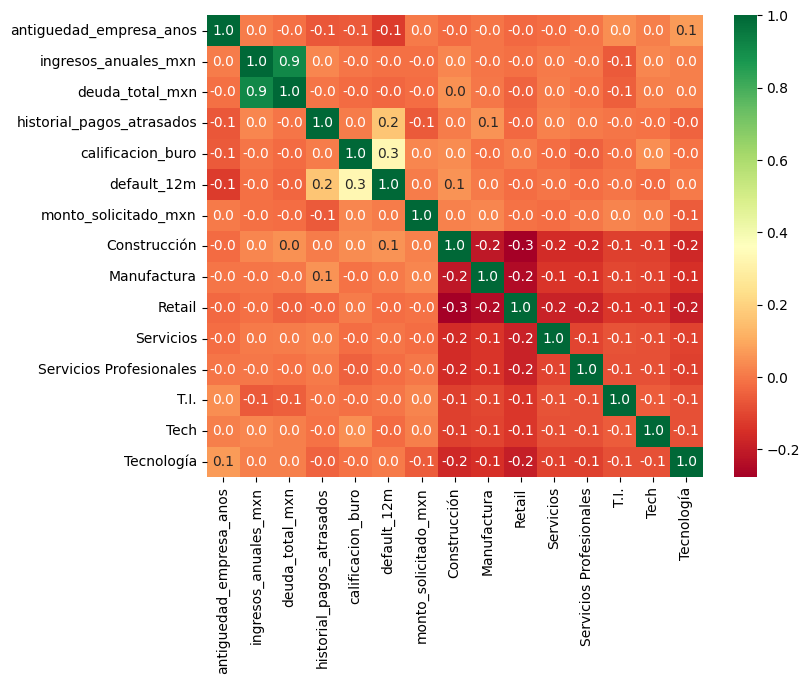

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))  
sns.heatmap(
    credit_data_platinum.select_dtypes(include=['number']).corr(),
    annot=True,
    fmt=".1f",         # Un decimal en las anotaciones
    cmap='RdYlGn',
    cbar=True 
)
plt.show()

ok. Hay alguna variables muy correlacionadas entre sí. hasta el momento no hay una correción fuerte con nuestra variable objetivo `dfaul_12m`. Agreguemos algunas otra variables.

In [38]:
credit_data_platinum["ratio_solicitud_ingresos"] = credit_data_platinum["monto_solicitado_mxn"] / credit_data_platinum["ingresos_anuales_mxn"]
credit_data_platinum["ratio_deuda_ingresos"] = credit_data_platinum["deuda_total_mxn"] / credit_data_platinum["ingresos_anuales_mxn"]
credit_data_platinum["carga_total_ingresos"] = (credit_data_platinum["deuda_total_mxn"] + credit_data_platinum["monto_solicitado_mxn"]) / credit_data_platinum["ingresos_anuales_mxn"]
credit_data_platinum["flag_ingresos_disponibles"] = credit_data_platinum["ingresos_anuales_mxn"].notna().astype(int)
credit_data_platinum["flag_antiguedad"] = credit_data_platinum["antiguedad_empresa_anos"].notna().astype(int)

credit_data_platinum.head()

id_cliente  antiguedad_empresa_anos  ingresos_anuales_mxn  deuda_total_mxn  \
0   COV-1000                     9.50            5388966.19       4093290.34   
1   COV-1001                     6.90             806689.27        184032.16   
2   COV-1002                    10.20            4721557.55       2875892.65   
3   COV-1003                    15.80             400301.58        284881.54   
4   COV-1004                     6.60            6110431.90       5935242.68   

   historial_pagos_atrasados  calificacion_buro  default_12m  \
0                          1                  4            0   
1                          3                  3            0   
2                          1                  2            0   
3                          1                  2            0   
4                          2                  0            0   

   monto_solicitado_mxn  Construcción  Manufactura  ...  Servicios  \
0            1042088.49             0            1  ...          0   
1             658716.30             1            0  ...          0   
2             656435.67             0            0  ...          0   
3             289018.04             0            0  ...          0   
4             694186.35             0            0  ...          0   

   Servicios Profesionales  T.I.  Tech  Tecnología  ratio_solicitud_ingresos  \
0                        0     0     0           0                      0.19   
1                        0     0     0           0                      0.82   
2                        1     0     0           0                      0.14   
3                        0     0     0           0                      0.72   
4                        0     0     0           0                      0.11   

   ratio_deuda_ingresos  carga_total_ingresos  flag_ingresos_disponibles  \
0                  0.76                  0.95                          1   
1                  0.23                  1.04                          1   
2                  0.61                  0.75                          1   
3                  0.71                  1.43                          1   
4                  0.97                  1.08                          1   

   flag_antiguedad  
0                1  
1                1  
2                1  
3                1  
4                1  

[5 rows x 21 columns]

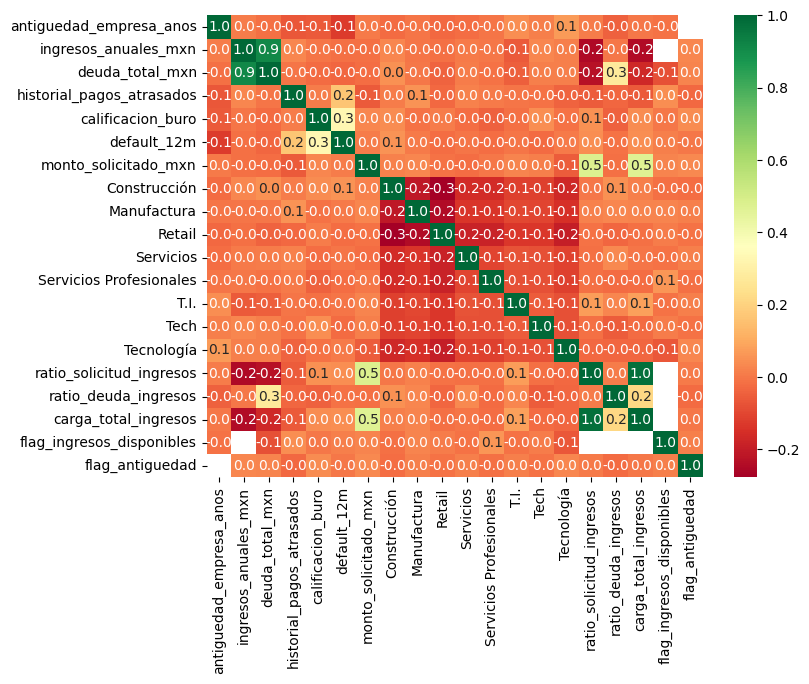

In [39]:
plt.figure(figsize=(8, 6))  
sns.heatmap(
    credit_data_platinum.select_dtypes(include=['number']).corr(),
    annot=True,
    fmt=".1f",         # Un decimal en las anotaciones
    cmap='RdYlGn',
    cbar=True 
)
plt.show()

# Escalado de datos

En el análisis exploratorio se identifico que las variables tienen escalas muy diferentes, así mismo, aun que se eliminaron los valores atípicos, las distribuciones de los datos estan sesgadas positivamente, es decir tiene una cola a la derecha de la distribución. Dado esto, se decidió escalar los datos utilizando RobustScaler.

El escalado de datos consiste en transformar las variables a una escala más reducida y manejable para los modelos de machine learning. RobustScaler es especialmente adecuado en presencia de valores atípicos o distribuciones con colas alargadas, ya que realiza la transformación utilizando la mediana y el rango intercuartílico (IQR). Matemáticamente, se define como:

$RobustScaler = \frac{X_i - \text{mediana}}{\text{IQR}}$

Dicho esto, crearemos la función `escalar_datos` la cual resive un dataframe y lo escala utilizando RobustScaler().

In [49]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def escalar_datos(no_escalar,df):
    X = df.drop(columns=no_escalar,axis=1)
    y = df[no_escalar]
    escalador = preprocessing.RobustScaler()
    X_nor = pd.DataFrame(escalador.fit_transform(X),
                         columns = X.columns,
                         index=X.index)
    dfnor = pd.concat([y,X_nor],axis=1)
    return dfnor,escalador

Dato que no todas las variables necesitan ser escaladas, seleccionemos aquellas características en la que sus datos están en el rango de 0 a 1.

In [50]:
# definimos las columnas que no se van a escalar
no_escalar = [col for col in credit_data_platinum.columns if credit_data_platinum[col].max()==1 and credit_data_platinum[col].min()==0]
print(no_escalar)

['default_12m', 'Construcción', 'Manufactura', 'Retail', 'Servicios', 'Servicios Profesionales', 'T.I.', 'Tech', 'Tecnología', 'flag_ingresos_disponibles', 'flag_antiguedad']


Ahora si, escalemos los datos.

In [52]:
df = credit_data_platinum.select_dtypes(include=['number'])
df_esc,esc_df = escalar_datos(no_escalar,
                          df = df)
df_esc.head()


default_12m  Construcción  Manufactura  Retail  Servicios  \
0            0             0            1       0          0   
1            0             1            0       0          0   
2            0             0            0       0          0   
3            0             0            0       1          0   
4            0             0            0       1          0   

   Servicios Profesionales  T.I.  Tech  Tecnología  flag_ingresos_disponibles  \
0                        0     0     0           0                          1   
1                        0     0     0           0                          1   
2                        1     0     0           0                          1   
3                        0     0     0           0                          1   
4                        0     0     0           0                          1   

   flag_antiguedad  antiguedad_empresa_anos  ingresos_anuales_mxn  \
0                1                     0.38                  0.54   
1                1                    -0.14                 -0.53   
2                1                     0.52                  0.38   
3                1                     1.64                 -0.62   
4                1                    -0.20                  0.70   

   deuda_total_mxn  historial_pagos_atrasados  calificacion_buro  \
0             0.87                       0.00               1.00   
1            -0.57                       2.00               0.50   
2             0.42                       0.00               0.00   
3            -0.53                       0.00               0.00   
4             1.54                       1.00              -1.00   

   monto_solicitado_mxn  ratio_solicitud_ingresos  ratio_deuda_ingresos  \
0                  0.92                      0.20                  0.61   
1                  0.35                      2.24                 -1.37   
2                  0.35                      0.02                  0.05   
3                 -0.20                      1.93                  0.43   
4                  0.40                     -0.07                  1.40   

   carga_total_ingresos  
0                  0.39  
1                  0.60  
2                 -0.08  
3                  1.49  
4                  0.69

Con estos datos escalados, veamos como se comportan los modelos en su estado por defecto. 

In [59]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Variables dependientes e independientes
independientes = df_esc.drop(columns=['default_12m'], axis=1) 
objetivo = df_esc['default_12m']  
X_train, X_test, Y_train, Y_test = train_test_split(
    independientes,
    objetivo,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

def model(Y_test, Y_train, X_test, X_train, model):
    model_instance = model()
    model_instance.fit(X_train, Y_train)
    y_pred = model_instance.predict(X_test)

    # Métricas
    acc = accuracy_score(Y_test, y_pred)
    prec = precision_score(Y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')
    results = {
        'Model': model.__name__,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4)
    }
    
    return model_instance, results

# Modelos que soportan NaNs nativamente
models = [
    HistGradientBoostingClassifier,
    DecisionTreeClassifier,
    RandomForestClassifier,
    XGBClassifier,
]

trained_models = []
results_list = []

for model_class in models:
    model_instance, results = model(Y_test, Y_train, X_test, X_train, model_class)
    trained_models.append(model_instance)
    results_list.append(results)

# DataFrame de resultados
results_df = pd.DataFrame(results_list)

# Ordenar por Accuracy
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df)



                            Model  Accuracy  Precision  Recall  F1-Score
0  HistGradientBoostingClassifier      0.91       0.90    0.91      0.90
2          RandomForestClassifier      0.91       0.87    0.91      0.88
3                   XGBClassifier      0.90       0.90    0.90      0.90
1          DecisionTreeClassifier      0.84       0.89    0.84      0.86


Podemos observar que los modelos muestran un buen ajuste a los datos; sin embargo, existe un problema importante: **las clases están fuertemente desbalanceadas**. Esto provoca que los modelos tiendan a sesgarse hacia la clase mayoritaria, que en este caso corresponde a la clase 0 (clientes que no han incumplido).

Si recordamos, el objetivo es “desarrollar un modelo predictivo que estime la probabilidad de que un nuevo solicitante de crédito PYME incurra en incumplimiento dentro de los siguientes 12 meses”. Bajo este escenario, los modelos entrenados hasta ahora son efectivos para identificar a quienes no incumplen, pero presentan pueden presentar dificultades al predecir a los clientes que sí lo hacen.

Por lo tanto, es necesario abordar este inconveniente. Una de las estrategias más adecuadas en este punto es aplicar técnicas de balanceo de clases para mejorar la capacidad predictiva del modelo frente a la clase minoritaria.

# Balanceo de clases